# Preprocess Audio Data

This notebook integrates the preprocessing steps into a single workflow.

1. **Load & link** Common Voice ↔︎ CoVoST (by `path`) → `merged_en_de.csv`  
2. **EDA** for **duration**, **SNR**, **vote score** (matplotlib-only)  
3. **Filtering**: translation present, duration bounds, SNR threshold, vote score > 0  
4. **Speaker-disjoint split** by `client_id` (deterministic, e.g., 98/1/1)  
5. **Audio standardization** per file: MP3→WAV(16k/mono/16-bit), loudness normalize, HP/LP, VAD trimming  
6. **Feature extraction**: log-Mel; **CMVN computed on TRAIN only** and applied to Dev/Test  
7. **Augmentation (TRAIN only)**: demo (speed 0.9/1.1), plus SpecAugment reference

## Requirements
- Files: Common Voice v4 (`validated.tsv`, `train.tsv`, `dev.tsv`, `test.tsv`, `invalidated.tsv`, `other.tsv`) + `clips/`; CoVoST v2 (`covost_v2.en_de.tsv`)
- Tools: **FFmpeg** on PATH
- Python: `pandas`, `numpy`, `soundfile`, `librosa`, `tqdm`, `webrtcvad`, `scipy`

## Configuration

In [1]:
from pathlib import Path

# Paths
CV_DIR   = Path("E:/datasets/common_voice_4")
CLIPS    = CV_DIR / "clips"
COVOST   = CV_DIR / "covost_v2.en_de.tsv"
MERGED_CSV = CV_DIR / "merged_en_de.csv"

CV_SPLITS = ["validated.tsv", "train.tsv", "dev.tsv", "test.tsv", "invalidated.tsv", "other.tsv"]

# Working & outputs
WORK_DIR = Path(".")
PROC_DIR = CV_DIR / "processed"
WAV_DIR  = PROC_DIR / "wav16k"
FEAT_DIR = PROC_DIR / "features"
AUG_DIR  = PROC_DIR / "aug"

for folder in [WORK_DIR, PROC_DIR, WAV_DIR, FEAT_DIR, AUG_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

# Thresholds
MIN_DUR = 0.5
MAX_DUR = 20.0
THRESH_SNR_DB = 10.0

# Split ratio
SPLIT_RATIO = (98, 1, 1)

# Audio/feature parameters
SR_TARGET = 16000
N_MELS = 80
WIN_MS = 25
HOP_MS = 10

# ffmpeg VAD-ish trimming
SIL_START_DB = -40
SIL_STOP_DB  = -40
SIL_PAD_S    = 0.3

# tiny dev helper
TINY_DEV_TARGET = 1000
MAX_PER_SPK_TINY = 2

## Imports

In [2]:
import os, sys, json, math, hashlib, subprocess, warnings
from typing import Optional, Tuple
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

USE_WEBRTCVAD = False
try:
    import webrtcvad
    vad = webrtcvad.Vad(2)
    USE_WEBRTCVAD = True
except Exception:
    warnings.warn("webrtcvad not available; using energy-based SNR/VAD proxies.")

## Helper Functions

In [3]:
def audio_duration_seconds(path: Path) -> Optional[float]:
    try:
        info = sf.info(str(path))
        return float(info.frames) / float(info.samplerate)
    except Exception:
        pass
    try:
        out = subprocess.check_output(
            ["ffprobe","-v","error","-show_entries","format=duration","-of","default=nk=1:nw=1", str(path)],
            stderr=subprocess.STDOUT
        ).decode().strip()
        return float(out)
    except Exception:
        return None

def load_audio_float_mono(path: Path) -> Tuple[Optional[np.ndarray], Optional[int]]:
    try:
        y, sr = sf.read(str(path), always_2d=False)
        if isinstance(y, np.ndarray) and y.ndim == 2:
            y = y.mean(axis=1)
        y = y.astype(np.float32, copy=False)
        max_abs = np.max(np.abs(y)) if y.size else 1.0
        if max_abs > 1.0:
            y = y / max_abs
        return y, sr
    except Exception:
        return None, None

def snr_db_energy_proxy(y: np.ndarray, sr: int, frame_ms: int = 30) -> Optional[float]:
    if y is None or y.size == 0:
        return None
    frame_len = max(int(sr * frame_ms / 1000), 1)
    frames = [y[i:i+frame_len] for i in range(0, len(y), frame_len) if len(y[i:i+frame_len]) == frame_len]
    if not frames:
        return None
    rms = np.array([np.sqrt(np.mean(f**2) + 1e-12) for f in frames])
    low  = np.percentile(rms, 20)
    high = np.percentile(rms, 80)
    Pn = max(low**2, 1e-12)
    Ps = max(high**2, 1e-12)
    return 10.0 * math.log10(Ps / Pn)

def snr_db_with_vad(y: np.ndarray, sr: int, frame_ms: int = 30) -> Optional[float]:
    if not USE_WEBRTCVAD or sr not in (8000,16000,32000,48000):
        return None
    x = (y * 32767.0).clip(-32768, 32767).astype(np.int16)
    bytes_data = x.tobytes()
    step = int(sr * frame_ms / 1000) * 2
    frames_b = [bytes_data[i:i+step] for i in range(0, len(bytes_data), step) if len(bytes_data[i:i+step]) == step]
    if not frames_b:
        return None
    voiced = []
    for f in frames_b:
        try:
            voiced.append(vad.is_speech(f, sr))
        except Exception:
            return None
    frame_len = int(sr * frame_ms / 1000)
    frames_f = [x.astype(np.float32)/32768.0 for x in [x[i:i+frame_len] for i in range(0, len(x), frame_len) if len(x[i:i+frame_len])==frame_len]]
    if len(frames_f) != len(voiced) or not frames_f:
        return None
    voiced_rms = [np.sqrt(np.mean(f**2) + 1e-12) for f,v in zip(frames_f, voiced) if v]
    noise_rms  = [np.sqrt(np.mean(f**2) + 1e-12) for f,v in zip(frames_f, voiced) if not v]
    if len(voiced_rms) < 1 or len(noise_rms) < 1:
        return None
    Ps = np.mean(np.array(voiced_rms)**2)
    Pn = np.mean(np.array(noise_rms)**2)
    return 10.0 * math.log10(max(Ps,1e-12)/max(Pn,1e-12))

def estimate_snr_db(path: Path) -> Optional[float]:
    y, sr = load_audio_float_mono(path)
    if y is None or sr is None:
        return None
    s = snr_db_with_vad(y, sr)
    if s is not None:
        return s
    return snr_db_energy_proxy(y, sr)

def assign_split_by_speaker(client_id: str, ratio=(98,1,1)) -> str:
    assert sum(ratio) == 100
    train_r, dev_r, test_r = ratio
    bucket = int(hashlib.md5(client_id.encode("utf-8")).hexdigest(), 16) % 100
    if bucket < train_r: return "train"
    elif bucket < train_r + dev_r: return "dev"
    else: return "test"

## 1. Load & Link (Common Voice ↔ CoVoST by `path`)

Writes `merged_en_de.csv` with columns: `audio_path`, `en_text`, `de_text`, and keeps `path` to enable vote joins.

In [4]:
# 1) Load CV split files and report sizes
total_possible = 0
for file in CV_SPLITS:
    path = CV_DIR / file
    try:
        df = pd.read_csv(path, sep="\t")
        print(f"{file:<20}: {len(df):>8} rows")
        total_possible += len(df)
    except Exception as e:
        print(f"{file:<20}: Error - {e}")

# 2) Load CoVoST & merge matching paths
covost_df = pd.read_csv(COVOST, sep="\t")
assert "path" in covost_df.columns, "CoVoST must contain 'path'"

# find translation col name
cands = [c for c in covost_df.columns if c.lower().startswith("translation") or c.endswith("_de")]
translation_col = cands[0] if cands else "translation"
if translation_col not in covost_df.columns:
    raise ValueError("Could not find translation column in CoVoST TSV.")

merged_dfs = []
for file_name in CV_SPLITS:
    path = CV_DIR / file_name
    if not path.exists(): 
        continue
    try:
        cv_df = pd.read_csv(path, sep="\t")
        matched = pd.merge(cv_df, covost_df, on="path")
        print(f"{file_name:<20}: matched {len(matched):>6} / {len(cv_df):>6} rows ({100 * len(matched)/max(len(cv_df),1):.2f}%)")
        matched["audio_path"] = matched["path"].apply(lambda q: str(CLIPS / q))
        en_col = "sentence" if "sentence" in matched.columns else "en_text"
        matched = matched[["audio_path", en_col, translation_col]].rename(columns={en_col:"en_text", translation_col:"de_text"})
        merged_dfs.append(matched)
    except Exception as e:
        print(f"{file_name:<20}: Merge error - {e}")

merged_df = pd.concat(merged_dfs, ignore_index=True) if merged_dfs else pd.DataFrame(columns=["audio_path","en_text","de_text"])
merged_df.to_csv(MERGED_CSV, index=False)
print(f"Total matched samples written to: {MERGED_CSV}")
merged_df.head(3)

C:\Users\Grace\AppData\Local\Temp\ipykernel_31836\3131101617.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t")


validated.tsv       :   854444 rows
train.tsv           :   232975 rows
dev.tsv             :    15531 rows
test.tsv            :    15531 rows
invalidated.tsv     :   124820 rows
other.tsv           :   155485 rows


C:\Users\Grace\AppData\Local\Temp\ipykernel_31836\3131101617.py:28: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  cv_df = pd.read_csv(path, sep="\t")


validated.tsv       : matched 799608 / 854444 rows (93.58%)
train.tsv           : matched 219399 / 232975 rows (94.17%)
dev.tsv             : matched  12830 /  15531 rows (82.61%)
test.tsv            : matched  15531 /  15531 rows (100.00%)
invalidated.tsv     : matched      0 / 124820 rows (0.00%)
other.tsv           : matched      0 / 155485 rows (0.00%)
Total matched samples written to: E:\datasets\common_voice_4\merged_en_de.csv


,audio_path,en_text,de_text
0,E:\datasets\common_voice_4\clips\common_voice_...,She'll be all right.,Sie wird schon in Ordnung sein.
1,E:\datasets\common_voice_4\clips\common_voice_...,All's well that ends well.,"Ende gut, alles gut."
2,E:\datasets\common_voice_4\clips\common_voice_...,Do you mean it?,Meinst du das wirklich so?


## 2. EDA (Duration, SNR, Vote Score)

We first visualize distributions (duration, SNR, votes), *then* apply the filtering thresholds to produce `merged_en_de_filtered.csv`.

For speed, plots sample the first ~10k rows, but **filtering is applied to the full dataset**.

### 2.1 Duration - Visualization

Duration (Visualization): 100%|██████████| 10000/10000 [00:55<00:00, 179.78it/s]


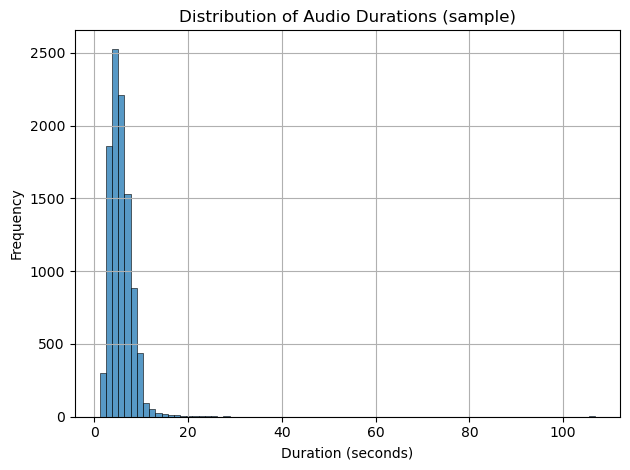

count    10000.000000
mean         5.657874
std          3.013082
min          1.109625
25%          3.941625
50%          5.252125
75%          6.868125
max        106.828125
Name: duration_sec, dtype: float64


In [5]:
# Duration distribution
df = pd.read_csv(MERGED_CSV)

# Calculate durations for first 10k samples
plot_sample = df.iloc[:10000].copy()
durations = []
for path in tqdm(plot_sample["audio_path"], desc="Duration (Visualization)"):
    try:
        duration = librosa.get_duration(path=path)
    except Exception as e:
        durations = None
    durations.append(duration)

# Add to DataFrame
plot_sample["duration_sec"] = durations
plot_sample = plot_sample.dropna(subset=["duration_sec"])

# Plot
plt.figure()
sns.histplot(plot_sample["duration_sec"], bins=80)
plt.title("Distribution of Audio Durations (sample)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print(plot_sample["duration_sec"].describe())

### 2.2 SNR - Visualization

SNR (Visualization): 100%|██████████| 10000/10000 [01:15<00:00, 132.27it/s]


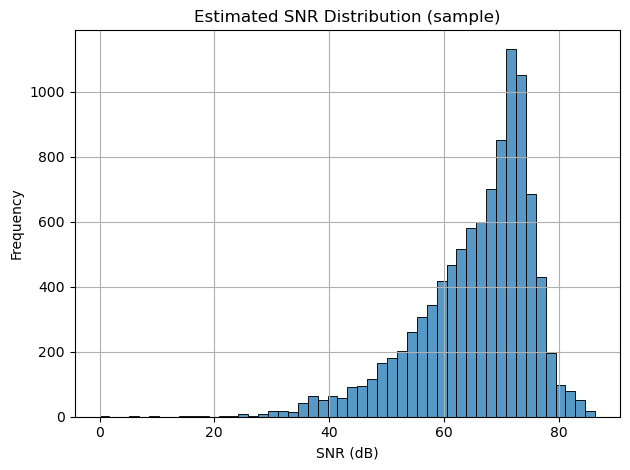

count    1.000000e+04
mean     6.558240e+01
std      1.003505e+01
min     -1.228269e-07
25%      6.029929e+01
50%      6.811722e+01
75%      7.271590e+01
max      8.636800e+01
Name: snr_db, dtype: float64

In [6]:
def estimate_snr_librosa(path, sr=SR_TARGET):
    try:
        y, _ = librosa.load(path, sr=SR_TARGET)
        total_energy = float(np.mean(y**2) + 1e-9)
        intervals = librosa.effects.split(y, top_db=20) # non-silent parts
        if intervals.size > 0:
            voiced = np.concatenate([y[s:e] for s,e in intervals])
            signal_energy = float(np.mean(voiced**2) + 1e-9)
        else:
            signal_energy = 0.0
        noise_energy = max(total_energy - signal_energy, 1e-9)
        return 10.0 * np.log10(signal_energy / noise_energy) # avoid zero div
    except Exception:
        return None

snr_vals = []
for path in tqdm(plot_sample["audio_path"], desc="SNR (Visualization)"):
    snr_vals.append(estimate_snr_librosa(path))
snr_viz = plot_sample.copy().assign(snr_db=snr_vals).dropna(subset=["snr_db"])

plt.figure()
sns.histplot(snr_viz["snr_db"], bins=50)
plt.title("Estimated SNR Distribution (sample)")
plt.xlabel("SNR (dB)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

snr_viz["snr_db"].describe()

### 2.3 Apply Filtering (full dataset)

Rules:
- Keep samples with **`MIN_DUR ≤ duration ≤ MAX_DUR`**
- Keep samples with **`SNR ≥ THRESH_SNR_DB`**

This produces `merged_en_de_filtered.csv` for the next steps.

In [11]:
def safe_duration(path: str) -> float | None:
    """Duration in seconds using librosa; None on failure."""
    try:
        return float(librosa.get_duration(path=path))
    except Exception:
        return None

def estimate_snr_librosa(filename: str, sr: int = SR_TARGET, top_db: int = 20) -> float | None:
    """
    Approximate SNR(dB) = 10*log10(signal_energy / noise_energy)
    where 'signal' = non-silent segments found by librosa.effects.split.
    """
    try:
        y, _ = librosa.load(filename, sr=sr, mono=True)
        if y.size == 0:
            return None
        total_e = float(np.mean(y**2) + 1e-9)
        intervals = librosa.effects.split(y, top_db=top_db)
        if intervals.size > 0:
            voiced = np.concatenate([y[s:e] for s, e in intervals])
            signal_e = float(np.mean(voiced**2) + 1e-9)
        else:
            signal_e = 0.0
        noise_e = max(total_e - signal_e, 1e-9)
        return 10.0 * np.log10(signal_e / noise_e)
    except Exception:
        return None

In [ ]:
# ---- compute duration if missing ----
if "duration_sec" not in df.columns:
    durs = []
    for ap in tqdm(df["audio_path"], desc="Compute duration (all)"):
        durs.append(safe_duration(str(ap)))
    df["duration_sec"] = durs

# ---- compute snr if missing ----
if "snr_db" not in df.columns:
    snrs = []
    for ap in tqdm(df["audio_path"], desc="Estimate SNR (all)"):
        snrs.append(estimate_snr_librosa(str(ap)))
    df["snr_db"] = snrs

# ---- persist metrics for audit/reuse ----
METRICS_CSV = CV_DIR / "merged_en_de_metrics.csv"
df.to_csv(METRICS_CSV, index=False)
print(f"Saved metrics → {METRICS_CSV}")

# ---- apply filters ----
before = len(df)
mask = (
    df["duration_sec"].between(MIN_DUR, MAX_DUR, inclusive="both") &
    (df["snr_db"] >= THRESH_SNR_DB)
)
filtered = df[mask].dropna(subset=["duration_sec","snr_db"]).copy()

OUT_FILTERED = CV_DIR / "merged_en_de_filtered.csv"
filtered.to_csv(OUT_FILTERED, index=False)

print(f"Kept {len(filtered)} / {before} rows "
      f"({len(filtered)/max(before,1)*100:.2f}%) → {OUT_FILTERED.name}")
print("\n[Kept] Duration stats:\n", filtered["duration_sec"].describe())
print("\n[Kept] SNR dB stats:\n", filtered["snr_db"].describe())

Compute duration (all):  47%|████▋     | 493410/1047368 [4:08:17<4:50:05, 31.83it/s]   

In [8]:
# Compute duration & SNR for ALL rows
all_durs, all_snrs = [], []

for p in tqdm(df["audio_path"], desc="Duration (full)"):
    try:
        d = librosa.get_duration(path=p)
    except Exception:
        d = None
    all_durs.append(d)

for p in tqdm(df["audio_path"], desc="SNR (full)"):
    try:
        s = estimate_snr_librosa(p)
    except Exception:
        s = None
    all_snrs.append(s)

df["duration_sec"] = all_durs
df["snr_db"] = all_snrs

# Apply filters
before = len(df)
mask = (
    df["duration_sec"].between(MIN_DUR, MAX_DUR, inclusive="both")
    & (df["snr_db"] >= THRESH_SNR_DB)
)

filtered = df[mask].dropna(subset=["duration_sec","snr_db"]).copy()

out_filtered = CV_DIR / "merged_en_de_filtered.csv"
filtered.to_csv(out_filtered, index=False)

print(f"Filtered: {len(filtered)} / {before} kept")
print(f"Saved: {out_filtered}")
filtered.head(3)

Duration (full):  19%|█▉        | 202381/1047368 [03:29<14:36, 963.79it/s]  


KeyboardInterrupt: 

## 3. Speaker-Disjoint Split (deterministic by `client_id`)

We map each sample back to `client_id` to assign **train/dev/test** splits.

In [ ]:
# To get client_id, read validated/train/dev/test TSVs and map 'path'->'client_id'
client_map = {}
for file in CV_SPLITS:
    p = CV_DIR / file
    if not p.exists(): 
        continue
    t = pd.read_csv(p, sep="\\t", usecols=[c for c in ["path","client_id"] if c in pd.read_csv(p, sep="\\t", nrows=0).columns])
    if t.empty or "path" not in t.columns:
        continue
    for r in t.itertuples(index=False):
        client_map[getattr(r, "path")] = getattr(r, "client_id") if hasattr(r, "client_id") else None

fdf = pd.read_csv(WORK_DIR / "merged_en_de_filtered.csv")
fdf["path"] = fdf["audio_path"].map(lambda q: os.path.basename(q))
fdf["client_id"] = fdf["path"].map(client_map).fillna("unknown_client")

fdf["split"] = fdf["client_id"].astype(str).map(lambda cid: assign_split_by_speaker(cid, SPLIT_RATIO))

# Save split map & seed manifest
split_map = fdf[["client_id","split"]].drop_duplicates().sort_values("client_id")
split_map.to_csv(WORK_DIR / "split_map.csv", index=False)

seed = fdf.copy()
seed.to_csv(WORK_DIR / "manifest_seed.csv", index=False)

# Tiny dev for quick iterations
dev = seed[seed["split"]=="dev"].copy()
tiny = dev.groupby("client_id", as_index=False).head(MAX_PER_SPK_TINY).head(TINY_DEV_TARGET)
tiny.to_csv(WORK_DIR / "tiny_dev.csv", index=False)

print("Saved: split_map.csv, manifest_seed.csv, tiny_dev.csv")

## 4. Audio Standardization (MP3→WAV + loudness + HP/LP + VAD trimming)

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def standardize_one(src_path: str) -> Optional[Path]:
    src = Path(src_path)
    if not src.exists():
        return None
    out_wav = WAV_DIR / (src.stem + ".wav")
    out_wav.parent.mkdir(parents=True, exist_ok=True)
    af = [
        "dynaudnorm=f=150:g=15",
        "highpass=f=40",
        "lowpass=f=7500",
        f"silenceremove=start_periods=1:start_threshold={SIL_START_DB}dB:start_silence={SIL_PAD_S}:stop_periods=1:stop_threshold={SIL_STOP_DB}dB:stop_silence={SIL_PAD_S}"
    ]
    cmd = [
        "ffmpeg","-nostdin","-y","-i", str(src),
        "-ac","1","-ar", str(SR_TARGET), "-sample_fmt","s16",
        "-af", ",".join(af),
        str(out_wav)
    ]
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        return out_wav
    except subprocess.CalledProcessError:
        return None

seed = pd.read_csv(WORK_DIR / "manifest_seed.csv")
paths = seed["audio_path"].astype(str).tolist()

with ThreadPoolExecutor(max_workers=8) as ex:
    futs = [ex.submit(standardize_one, p) for p in paths]
    for _ in tqdm(as_completed(futs), total=len(futs), desc="Standardizing WAVs"):
        _ = _.result()

wav_manifest = seed.copy()
wav_manifest["audio_wav"] = wav_manifest["audio_path"].map(lambda p: (WAV_DIR / Path(p).name).with_suffix(".wav").as_posix())
wav_manifest.to_csv(WORK_DIR / "manifest_wav.csv", index=False)
print("Saved: manifest_wav.csv")

## 5. Feature Extraction (log-Mel) + **Train-only CMVN**

In [ ]:
def logmel_from_wav(path_wav: Path, sr_target: int = SR_TARGET, n_mels: int = N_MELS,
                    win_ms: int = WIN_MS, hop_ms: int = HOP_MS) -> Optional[np.ndarray]:
    try:
        y, sr = sf.read(str(path_wav), always_2d=False)
        if isinstance(y, np.ndarray) and y.ndim == 2:
            y = y.mean(axis=1)
        if sr != sr_target:
            y = librosa.resample(y.astype(np.float32), orig_sr=sr, target_sr=sr_target)
            sr = sr_target
        S = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=n_mels,
            n_fft=int(sr*win_ms/1000), hop_length=int(sr*hop_ms/1000), win_length=int(sr*win_ms/1000),
            center=True, power=2.0
        )
        logmel = np.log(np.maximum(S, 1e-10)).astype(np.float32)
        return logmel
    except Exception:
        return None

def extract_and_save_features(manifest_csv: Path, out_dir: Path) -> pd.DataFrame:
    dfm = pd.read_csv(manifest_csv)
    out_paths, shapes = [], []
    for _, row in tqdm(dfm.iterrows(), total=len(dfm), desc=f"Extract feats -> {out_dir.name}"):
        wav_p = Path(row["audio_wav"])
        if not wav_p.exists():
            out_paths.append(""); shapes.append(""); continue
        F = logmel_from_wav(wav_p)
        if F is None:
            out_paths.append(""); shapes.append(""); continue
        out_path = out_dir / (wav_p.stem + ".npy")
        out_dir.mkdir(parents=True, exist_ok=True)
        np.save(out_path, F)
        out_paths.append(out_path.as_posix())
        shapes.append(f"{F.shape[0]}x{F.shape[1]}")
    dfm["feat_npy"] = out_paths
    dfm["feat_shape"] = shapes
    return dfm

LOGMEL_DIR = FEAT_DIR / "logmel"
df_feats = extract_and_save_features(WORK_DIR / "manifest_wav.csv", LOGMEL_DIR)

# Train-only CMVN
train_mask = df_feats["split"]=="train"
train_feat_paths = df_feats.loc[train_mask, "feat_npy"].replace("", np.nan).dropna().tolist()

sum_feat = None
sum_sq   = None
count    = 0
for p in tqdm(train_feat_paths, desc="CMVN (train) accumulate"):
    F = np.load(p)
    if sum_feat is None:
        sum_feat = F.sum(axis=1)
        sum_sq   = (F**2).sum(axis=1)
    else:
        sum_feat += F.sum(axis=1)
        sum_sq   += (F**2).sum(axis=1)
    count += F.shape[1]

cmvn = {}
if count > 0:
    mean = (sum_feat / count).astype(np.float32)
    var  = (sum_sq / count - mean**2).astype(np.float32)
    std  = np.sqrt(np.maximum(var, 1e-8)).astype(np.float32)
    cmvn = {"mean": mean.tolist(), "std": std.tolist()}
    with open(WORK_DIR / "cmvn_train.json", "w") as f:
        json.dump(cmvn, f)
    print("Saved: cmvn_train.json")

# Apply CMVN to all .npy in-place
if cmvn:
    mean = np.array(cmvn["mean"], dtype=np.float32)[:, None]
    std  = np.array(cmvn["std"], dtype=np.float32)[:, None]
    for p in tqdm(df_feats["feat_npy"].replace("", np.nan).dropna().tolist(), desc="Apply CMVN"):
        F = np.load(p)
        Fn = (F - mean) / std
        np.save(p, Fn)

df_feats.to_csv(WORK_DIR / "manifest_features.csv", index=False)
print("Saved: manifest_features.csv")

## 6. Augmentation (**Train only**; demo subset)

Speed perturbation x0.9/x1.1 on a small subset to illustrate the mechanism. Extend as needed.

In [ ]:
def augment_speed(src_wav: Path, dst_wav: Path, factor: float) -> bool:
    cmd = ["ffmpeg","-nostdin","-y","-i", str(src_wav), "-filter:a", f"atempo={factor}", str(dst_wav)]
    try: subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE); return True
    except subprocess.CalledProcessError: return False

train_wavs = df_feats[df_feats["split"]=="train"]["audio_wav"].replace("", np.nan).dropna().tolist()
for wav_str in tqdm(train_wavs[:200], desc="Augment (speed demo)"):
    w = Path(wav_str)
    if not w.exists(): continue
    out_09 = AUG_DIR / f"{w.stem}_sp0.9.wav"
    out_11 = AUG_DIR / f"{w.stem}_sp1.1.wav"
    _ = augment_speed(w, out_09, 0.9)
    _ = augment_speed(w, out_11, 1.1)

print("Augmentation demo done (first 200 files).")

## Notes

- Filtering **after visualization** ensures your thresholds are data‑driven.  
- All **learned statistics** are from **train only** (no leakage).  
- Scale out by parallelizing heavy loops and/or sharding manifests.